In this notebook, we'll illustrate the paper "SAMSelect: An Automated Spectral Index Search for Marine Debris using Segment-Anything." SAMSelect is an automated algorithm designed to identify the best spectral band combinations for creating three-channel visualizations from multispectral imagery. Initially developed for detecting marine debris in Sentinel-2 data, the algorithm is highly adaptable and can be applied to both terrestrial and marine contexts. By building on the Segment Anything Model (SAM), SAMSelect approximates the process of visual inspection typically performed by domain experts. Using a few annotated objects-of-interest, SAM automates the search for the best visualizations, quickly testing numerous spectral band combinations and exhaustively exploring a vast search space, as illustrated in the figure below.

![SAMSelect](.doc/SAMSelect.png)

This tutorial is designed to point out the effectiveness of the algorithm and make it more accessible to new users. In the following guide, we will apply SAMSelect to the Sentinel-2 image of the Plastic Litter Project PLP targets acquired in 2021. This example will be used as a means of presenting, in detail, the flow of the entire process of the algorithm-from preprocessing and data processing to the visualization phase.

## Set-up environment
Before running this demo, please follow these instructions in your terminal:
```conda create --n samselect
conda activate samselect
conda install pytorch=2.4.1 torchvision=0.17.2 torchaudio=2.2.2 pytorch-cuda=12.4 -c pytorch -c nvidia
conda env update --f environment.yml```

In [1]:
import sys; sys.path.append('..')
import os
import requests

# Custom modules
from models.spectral_indices import execute_ndvi, execute_fdi, execute_pca
from models.samselect import samselect
from visualization.viz_patches_entire import plot_patches
from visualization.viz_spectraldata import get_spectral_statistics

# Set the working directory explicitly as filepaths would not function in the .py scripts
os.chdir("..")
print("Updated working directory:", os.getcwd())

Updated working directory: /mnt/guanabana/raid/home/dalen024/SAMSelect


## Set-up the ViT model
Start by downloading the Segment Anything checkpoint and saving it to the `data/models folder`. For faster processing and better segmentation performance, we recommend using the ViT-B model.

In [2]:
# Get the root directory
#root = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Define the path where the model should be saved at the root level
model_dir = os.path.join("data", "models")
model_url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth" # Download ViT-B encoder from Meta AI
model_filename = "sam_vit_b_01ec64.pth"
model_path = os.path.join(model_dir, model_filename)

# Create the directory if it doesn't exist
os.makedirs(model_dir, exist_ok=True)

# Download the model file if it's not already present
if not os.path.exists(model_path):
    print(f"Downloading model from {model_url}...")
    response = requests.get(model_url)
    with open(model_path, 'wb') as f:
        f.write(response.content)
    print(f"Model saved to '{model_path}'")
else:
    print(f"Model already exists at '{model_path}'")


Model already exists at 'data/models/sam_vit_b_01ec64.pth'


## Set-up GEE downloader functions for PLP2021 data


### Set-up packages specifically for downloading GEE-data; skip if own data is used

In [3]:
# Install necessary libraries for the notebook (geemap and earthengine-api)
%pip install geemap
%pip install earthengine-api
%pip install geedim
%pip install xarray
%pip install localtileserver 
import geemap
import ee
import geopandas as gpd
from shapely.geometry import Polygon

# Initialize the Earth Engine API
try:
    ee.Initialize()
except Exception as e:
    # If initialization fails, authenticate
    print("Initializing Earth Engine...")
    ee.Authenticate()
    ee.Initialize()

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_0JLhFqfSY1uiEaW?source=Init


### Helper functions for downloading

In [4]:
import math

def create_bounding_box(lat_centroid, lon_centroid, size_meters=1280):
    # Convert the size from meters to degrees (for latitude)
    lat_size_deg = size_meters / 111000  # 1 degree of latitude = 111000 meters

    # Convert the size from meters to degrees (for longitude), adjusted by the latitude
    lon_size_deg = size_meters / (111000 * math.cos(math.radians(lat_centroid)))  # Adjust for curvature of Earth

    # Calculate the corners of the bounding box in degrees
    coordinates = [
        [lon_centroid - lon_size_deg / 2, lat_centroid - lat_size_deg / 2],  # Bottom-left
        [lon_centroid + lon_size_deg / 2, lat_centroid - lat_size_deg / 2],  # Bottom-right
        [lon_centroid + lon_size_deg / 2, lat_centroid + lat_size_deg / 2],  # Top-right
        [lon_centroid - lon_size_deg / 2, lat_centroid + lat_size_deg / 2],  # Top-left
        [lon_centroid - lon_size_deg / 2, lat_centroid - lat_size_deg / 2]   # Closing the polygon
    ]

    return coordinates

def fetch_and_process(collection, date, bands, bounding_box):
    """Fetch images from the specified collection and process them."""
    images = collection.filterDate(date, date.advance(1, 'day')).filterBounds(bounding_box)
    count = images.size().getInfo()

    # Select the bands you need and filter for those that contain them
    # We filter them here as band order can vary slightly between images (auxillary bands: QA10, QA20, QA60, MSK_CLASSI_*)
    # Without this step, the download of these heterogeneous images would fail
    images = images.select(bands)

    # Slightly convoluted; but basically sometimes the bounding box overlaps with several Sentinel-2 tiles
    # If this is the case (i.e., count > 1), then mosaic them into a single ee.Image object
    # In the other case, we simply return the single image
    if count > 0:
        # Get the native CRS from the first image in the collection
        crs = images.first().select(0).projection().crs()

        if count > 1:
            print("Mosaicking multiple images.")
            mosaic_image = images.mosaic()

            # Reproject the mosaic back to the original CRS
            return mosaic_image, crs
        else:
            print(f"Found single image: {images.first().get('system:id').getInfo()}")
            return images.first(), crs
    return None, None

### Download Sentinel-2 image

In [5]:
def download_single_s2img(date, bands, output_dir, lat_centroid, lon_centroid):
    """
    Downloads a single Sentinel-2 image, checking if the image already exists locally.
    If L2A data is unavailable, it falls back to L1C data.
    
    Args:
        date (str): The acquisition date of the Sentinel-2 product (e.g., '2019-04-24').
        output_dir (str): Directory to save the downloaded image.
        lat_centroid (float): Latitude of the center point.
        lon_centroid (float): Longitude of the center point.
    
    Returns:
        None. The image is saved as a GeoTIFF file in the specified directory.
    """
    # Clean up the date format to use it in filenames
    given_name = date.replace("-", "")  # Use the date as part of the name
    
    # Define the output directory to store the data
    output_data_dir = os.path.join("data", output_dir)
    os.makedirs(output_data_dir, exist_ok=True)
    
    # Generate the output filename based on the given date
    file_name = f"{given_name}.tif"  # Use the formatted date as the filename
    
    # Build potential file paths for L2A and L1C data
    l2a_path = os.path.join(output_data_dir, f"L2A_{file_name}")
    l1c_path = os.path.join(output_data_dir, f"L1C_{file_name}")
    print(l2a_path)

    # Skip download if the file already exists
    #if os.path.exists(l2a_path) or os.path.exists(l1c_path):
    #    print(f"File at '{file_name}' already exists. Skipping download.")
    #    return  # Skip processing if either file exists

    print('\n' + '#'*40)
    print(f"Processing file: '{file_name}'")
    
    # Load Sentinel-2 image collections (L2A and L1C)
    sentinel2_sr = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')  # L2A data
    sentinel2_toa = ee.ImageCollection('COPERNICUS/S2_HARMONIZED')  # L1C data

    # Extract the date as a timestamp
    date = ee.Date(date)
    
    # Create the bounding box (lat-lon; EPSG:4326)
    coordinates = create_bounding_box(lat_centroid, lon_centroid)  # Adjust for 1280 meters (~0.115°)
    bounding_box = ee.Geometry.Polygon(coordinates)
    
    # Save the centroid as a shapefile
    from shapely.geometry import Point
    centroid_point = gpd.GeoDataFrame(
        {'type': 1, # For SAM, we need to indicate wheter prompts are foreground (==1) or background (==0)
        'geometry': [Point(lon_centroid, lat_centroid)]},
        crs="EPSG:4326"
    )
    centroid_shapefile_path = os.path.join(output_data_dir, f"{given_name}_pt.shp")
    centroid_point.to_file(centroid_shapefile_path)

    # Attempt to fetch and process the L2A image
    #bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']
    sentinel2, crs = fetch_and_process(sentinel2_sr, date, bands, bounding_box)
    prefix = 'L2A'  # Default to L2A prefix for exporting

    # If L2A is not available, try fetching the L1C image
    if sentinel2 is None:
        sentinel2, crs = fetch_and_process(sentinel2_toa, date, bands, bounding_box)
        prefix = 'L1C'

    # If an image was found, export it to the output directory
    if sentinel2:
        # Define the filename and export path
        export_path = os.path.join(output_data_dir, f"{prefix}_{file_name}")

        # Export the image with indices to the specified directory
        geemap.download_ee_image(sentinel2,
                                 filename=export_path,
                                 scale=10,
                                 region=bounding_box,
                                 crs="EPSG:4326", #crs, #<= Use if original CRS is desired
                                 overwrite=True)
        print(f"File saved to '{export_path}'")
        
        return sentinel2.clip(bounding_box) # Return the clipped Sentinel-2 file for drawing polygon annotations
    print('#'*40)

In [6]:
# Call the function for downloading the Sentinel-2 tile
sceneid = "PLP2021"
band_list = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']
lat_centroid = 39.0395788
lon_centroid = 26.5246818
sentinel2_image = download_single_s2img(
    date='2021-06-21',
    bands = band_list,
    output_dir=sceneid,
    lat_centroid=lat_centroid,
    lon_centroid=lon_centroid
)

data/PLP2021/L2A_20210621.tif

########################################
Processing file: '20210621.tif'
Found single image: COPERNICUS/S2_SR_HARMONIZED/20210621T085601_20210621T090754_T35SMD


L2A_20210621.tif: |          | 0.00/517k (raw) [  0.0%] in 00:00 (eta:     ?)

File saved to 'data/PLP2021/L2A_20210621.tif'


### Create polygon annotation
While normally, the user should input polygon annotations for the features-of-interest using the `_qualitative_poly.shp` naming convention. In this case, we manually define the coordinates corresponding to the HDPE target of PLP2021 and save these as a shapefile for reproducibility

In [7]:
# Initialize the map
Map = geemap.Map()

# Visualize the image by selecting a specific band
vis_params = {
    'bands': ['B4', 'B3', 'B2'],  # True-colour bands. Alternatively, try a combination of [B3, B8, B8A]
    'min': 0, 
    'max': 3000, 
    'gamma': 1.4
}

# Add the Sentinel-2 image to the map
Map.addLayer(sentinel2_image, vis_params, "Sentinel-2 Image")

# Set the map center and zoom level
Map.set_center(lon=lon_centroid, lat=lat_centroid, zoom=17)

# Enable the drawing tools (polygon drawing)
Map.draw_features
Map


Map(center=[39.0395788, 26.5246818], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Se…

In [13]:
feature = Map.draw_features

try:
    print(len(feature))
    # Check if a feature was drawn (i.e., if the list is not empty)
    assert len(feature) > 0, "No polygon has been drawn. Drawing a polygon is required for running SAMSelect."
    
    # If a polygon is drawn, proceed to export it
    fc = ee.FeatureCollection(feature)
    
    # Export the FeatureCollection to a shapefile
    output_path = os.path.join("data", sceneid, "drawn_qualitative_poly.shp")
    print(output_path)
    geemap.ee_export_vector(fc, output_path, verbose=True)

    print(f"Shapefile saved to {output_path}")

except AssertionError as e:
    # If no feature was drawn, print the error message
    print(f"Error: {e}")

1
data/PLP2021/drawn_qualitative_poly.shp
Generating URL ...
Please wait ...
Data downloaded to /mnt/guanabana/raid/home/dalen024/SAMSelect/data/PLP2021/drawn_qualitative_poly.shp
Shapefile saved to data/PLP2021/drawn_qualitative_poly.shp


### Visualize in true-colour

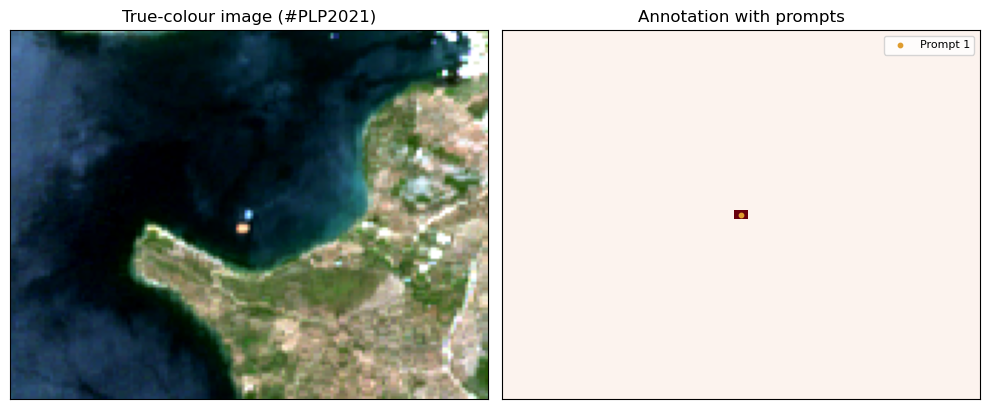

In [14]:
import importlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import utils.image_predictions  # Import the whole module
importlib.reload(utils.image_predictions)  # Reload the module
from utils.image_predictions import get_img  # Re-import the function
import torch

# Define custom colormap
binary_cmap = ListedColormap(['#FCF3EE', '#68000D'])

# Load data
images_vis, batch_label, point_prompts, point_labels, patch_ids = get_img(sceneid, band_list, ['B4', 'B3', 'B2'], 'bc', 'S2A', 'L2A')

# Prepare figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Plot True-Color Image (RGB)
axes[0].imshow(images_vis[0])  # Assuming images_vis is a batch and [0] gets the first image
axes[0].tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
axes[0].set_title(f"True-colour image (#{sceneid})")

# Plot Binary Label with Prompts
label = batch_label[0]  # Assuming batch_label is a batch, [0] gets the first label
axes[1].imshow(label.permute(1, 2, 0), cmap=binary_cmap)  # Ensure the label is permuted correctly for RGB display
axes[1].tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
axes[1].set_title("Annotation with prompts")

# Remove padding from point prompts
valid_mask = ~torch.all(point_prompts == 0, dim=-1)  # Mask where points are not [0, 0]
valid_points = point_prompts[valid_mask].numpy()  # Extract valid points as a NumPy array
valid_p_labels = point_labels[point_labels != 99].numpy()  # Extract valid patch IDs

# Plot point prompts on the label subplot
for point, p_label in zip(valid_points, valid_p_labels):
    color = '#DF9C2E' if p_label == 1 else 'red'
    axes[1].scatter(point[0], point[1], c=color, s=10, label=f'Prompt {p_label}')

# Add legend for points
axes[1].legend(loc='upper right', fontsize=8)

# Display the subplots
plt.tight_layout()
plt.show()


# Execute SAMSelect

### `samselect` Function Arguments

- **`sceneid`** (`str`):  
    - **Description**: The scene identifier, used to specify the dataset or region you are working with.  
    - **Example**: `'PLP2021_test'`

- **`band_list`** (`list of str`):  
    - **Description**: Specifies the available multispectral bands in the TIFF files. For Sentinel-2 data, it might look like `["B1", "B2", "B3", "B4", ...]`  
    - **Example**: `['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']` For Sentinel-2 L2A data

- **`narrow_search_bands`** (`list of str, optional`):  
    - **Description**: Limits the spectral search space to a subset of the bands in `band_list`. This can significantly reduce computation time. Note that the bands listed here must exactly match those provided in `band_list`.  
    - **Example**: `['B2', 'B3', 'B4', 'B8', 'B8A']` for narrowing down analysis to visible and near-infrared bands
    - **Default**: `None`

- **`scaling`** (`str`):  
    - **Description**: The normalization function applied to the reflectance data to scale into a `[0, 255]` range for RGB data. Default is percentile scaling (1%-99%), but different scaling options are available in the dataloader.  
    - **Example**: `'percentile_1-99'` normalize values between the 1st and 99th percentiles

- **`equation`** (`list of str`):  
    - **Description**: Specifies the type of visualizations SAMSelect will compute. The following visualization options are available:  
        - **`bc`**: Band Composites / false-colour composites using three spectral bands  
        - **`ndi`**: Normalized Difference Indices, such as NDVI or NDWI  
        - **`ssi`**: Spectral Shape Indices, such as the Floating Algae Index  
        - **`top`**: RSI-top10, which uses a similar approach to `bc` but instead of individual spectral bands, the top-10 most informative indices (NDIs and SSIs) are assigned to RGB channels. This option requires prior calculation of NDIs and SSIs  
    - **Example**: `['bc', 'ndi', 'ssi', 'top']`

- **`model_type`** (`str`):  
    - **Description**: Defines the image encoder variant for SAM. Default is `vit_b` which is recommended for its performance and computation time.  
    - **Example**: `'vit_b'` ViT-Base

- **`sensor_type`** (`str`):  
    - **Description**: Specifies the satellite sensor used to collect the images. Options are `S2A` (Sentinel-2A) and `S2B` (Sentinel-2B). Note: this setting is required for SSI and FDI calculations. Support for other satellites is not yet integrated.  
    - **Example**: `'S2B'` (Sentinel-2B satellite)


In [15]:
from models.samselect import samselect
equation_list = ['bc', 'ndi'] # For demonstration purposes, we limit the visualization modules to BC and NDIs;
for eq in equation_list: 
    samselect(sceneid,
            band_list, 
            narrow_search_bands = ['B1', 'B2', 'B3', 'B4', 'B8', 'B8A'], # For demonstration purposes, we run it on VNIR bands; We recommend running an exhaustive search (use None)
            scaling = 'percentile_1-99',  # Normalization function for DN into RGB values (0, 255)
            equation = eq,
            model_type = 'vit_b',
            sensor_type = 'S2B',
            atm_level = 'L2A')

Results already exist at 'data/processed/PLP2021_bc_vit_b_results.csv'. Skipping execution.
Results already exist at 'data/processed/PLP2021_ndi_vit_b_results.csv'. Skipping execution.


# Visualize SAMSelect outputs
## Spectral band selection

---------------------------------------- Scene: PLP2021 with bc ----------------------------------------
    sceneid band_combination    mask_level  miou
45  PLP2021     B1 | B3 | B8  jaccard_lvl3  60.0
46  PLP2021    B1 | B3 | B8A  jaccard_lvl3  60.0
47  PLP2021     B1 | B4 | B8  jaccard_lvl3  60.0
48  PLP2021    B1 | B4 | B8A  jaccard_lvl3  60.0
49  PLP2021    B1 | B8 | B8A  jaccard_lvl3  60.0

---------------------------------------- Scene: PLP2021 with ndi ----------------------------------------
    sceneid band_combination    mask_level  miou
40  PLP2021          B3 | B8  jaccard_lvl3  55.0
36  PLP2021          B2 | B4  jaccard_lvl3  54.5
44  PLP2021         B8 | B8A  jaccard_lvl3  54.5
32  PLP2021          B1 | B4  jaccard_lvl3  52.9
37  PLP2021          B2 | B8  jaccard_lvl3  52.4



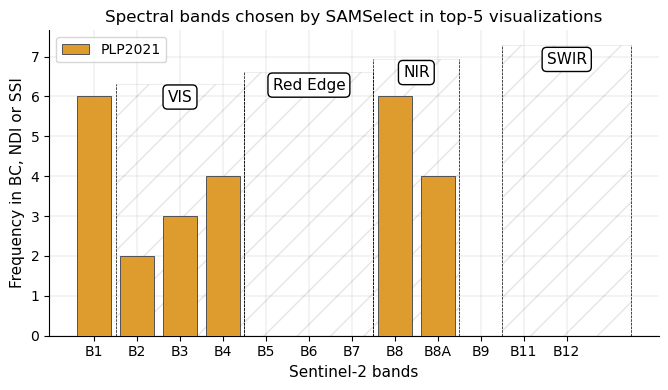

Top-5 most frequently selected spectral bands saved in 'doc/figures/PLP2021_band_frequency
Best visualization found by SAMSelect is: 'bc' with an mIoU score of 60.0%
Using bands: ['B1', 'B3', 'B8']


In [16]:
from visualization.viz_spectraldata import get_spectral_statistics
top1_combination, top1_equation = get_spectral_statistics(sceneid, band_list, equation_list, 'vit_b', spectral_shading=True)


## Visualization of output patches


Device used: cuda
Additional metrics for top-1 visualization ('['B1', 'B3', 'B8']')
precision: 1.000
accuracy: 1.000
recall: 0.600
fscore: 0.750
kappa: 0.750
jaccard: 0.600


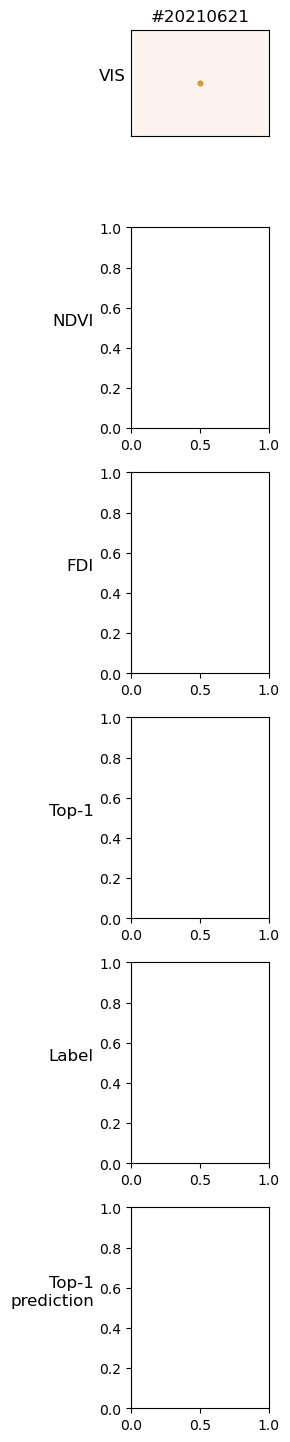

In [27]:
import visualization.viz_patches_entire  # Import the whole module
importlib.reload(visualization.viz_patches_entire)  # Reload the module
from visualization.viz_patches_entire import plot_patches
from utils.image_predictions import get_img, get_img_pred

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os
import torch

def plot_patches_demo(sceneid, band_list, top1_combination, top1_equation, sensor_type, atm_level, mask_level):
    # Make patches for true-colour (VIS), NDVI, and FDI
    images_vis, batch_label, point_prompts, point_labels, patch_ids = get_img(sceneid, band_list, ['B4', 'B3', 'B2'], 'bc', sensor_type, atm_level)  # True-colour
    images_ndvi = get_img(sceneid, band_list, ['B8', 'B4'], 'ndi', sensor_type, atm_level)[0]  # NDVI
    images_fdi = get_img(sceneid, band_list, ["B8", "B6", "B11"], 'fdi', sensor_type, atm_level)[0]  # FDI

    # Retrieve top-1 results from SAMSelect
    images_top1 = get_img(sceneid, band_list, top1_combination, top1_equation, sensor_type, atm_level)[0]  # RSI-top10
    images, batch_label, point_prompts, point_labels, batch_patchid, masks_lst = get_img_pred(sceneid, band_list, top1_combination, top1_equation, sensor_type, atm_level, mask_level)
        
    # Plot all images in a single column
    no_img = 1  # Set to 1 for a single column of images
    no_rows = 6
    fig, axes = plt.subplots(no_rows, no_img , figsize=(no_img * 3, no_rows * 2.5))

    binary_cmap = ListedColormap(['#FCF3EE', '#68000D'])

    ### Data ###
    # Row 1: True-colour
    for i, (image, patchid) in enumerate(zip(images_vis, patch_ids)):
        axes[i].imshow(image)
        axes[i].tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
        axes[i].set_title(f"#{patchid}")

    # Row 2: NDVI
    for i, image_ndvi in enumerate(images_ndvi):
        axes[i].imshow(image_ndvi)
        axes[i].tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

    # Row 3: FDI
    for i, image_fdi in enumerate(images_fdi):
        axes[i].imshow(image_fdi)
        axes[i].tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

    # Row 4: Top-1 from SAMSelect
    for i, image_top1 in enumerate(images_top1):
        axes[i].imshow(image_top1)
        axes[i].tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

    # Row 5: Label / Reference
    for i, (label, points, p_labels) in enumerate(zip(batch_label.squeeze(0), point_prompts, point_labels)):
        # Check if the label is 2D or 3D
        if label.dim() == 3:  # If it's 3D, apply permute
            axes[i].imshow(label.permute(1, 2, 0), cmap=binary_cmap)
        else:  # If it's 2D, just plot it directly
            axes[i].imshow(label, cmap=binary_cmap)
        
        axes[i].tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

        # Plot point prompts used for prediction
        valid_points = points[~torch.all(points == 0, dim=1)].numpy()
        valid_p_labels = p_labels[p_labels != 99].numpy()

        # Plot each point with the appropriate color
        for point, p_label in zip(valid_points, valid_p_labels):
            color = '#DF9C2E' if p_label == 1 else 'red'
            axes[i].scatter(point[0], point[1], c=color, s=10, label='Prompt')

    # Row 6: Top-1 prediction
    for i, (mask, points, p_labels) in enumerate(zip(masks_lst, point_prompts, point_labels)):
        axes[i].imshow(mask.astype(int), cmap=binary_cmap)
        axes[i].tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
        
        valid_points = points[~torch.all(points == 0, dim=1)].numpy()
        valid_p_labels = p_labels[p_labels != 99].numpy()

        # Plot each point with the appropriate color
        for point, p_label in zip(valid_points, valid_p_labels):
            color = '#DF9C2E' if p_label == 1 else 'red'
            axes[i].scatter(point[0], point[1], c=color, s=10, label='Prompt')

    # Text for row labels
    rows = ['VIS', 'NDVI', 'FDI', 'Top-1', 'Label', 'Top-1\nprediction']
    for ax, row in zip(axes, rows):
        ax.set_ylabel(row, rotation=0, size='large', horizontalalignment='right')

    # Save
    plt.tight_layout()
    os.makedirs("doc/figures", exist_ok=True)
    plt.savefig(f"doc/figures/{sceneid}_patches_demo.png", dpi=600, transparent=False)
    plt.show()


plot_patches_demo(sceneid, band_list, top1_combination, top1_equation, 'S2A', 'L2A', 'level-3') # Hard-coded to select mask-level 3 from the SAM-predictions


In [ ]:
def create_polygon_and_save(geojson, sceneid):
    # Create the polygon from the GeoJSON coordinates
    polygon = Polygon(geojson["coordinates"][0])
    
    # Create the output path and directory
    output_path = os.path.join("data", sceneid, f"hdpe_qualitative_poly.shp")
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    print(output_path)
    
    # Save the polygon as a shapefile
    gpd.GeoDataFrame({'geometry': [polygon]}, crs="EPSG:4326").to_file(output_path)
    print(f"Polygon saved to {output_path}")

# Example usage
geojson = {
    "type": "Polygon",
    "coordinates": [
        [
            [26.524585, 39.039791],
            [26.524966, 39.039691],
            [26.524773, 39.039333],
            [26.524327, 39.039462],
            [26.524585, 39.039791]
        ]
    ]
}
create_polygon_and_save(geojson, sceneid)
